In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

class SequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        # for subfolder in ['1', '2', '4', '8']:
        for subfolder in ['1']:
        # for subfolder in ['8']:
            subfolder_path = os.path.join(self.root_dir, subfolder)
            for sequence_folder in os.listdir(subfolder_path):
                sequence_path = os.path.join(subfolder_path, sequence_folder)
                images = [os.path.join(sequence_path, img) for img in sorted(os.listdir(sequence_path))]

                # Extract label from the file name (assuming all images in a sequence have the same label)
                label_from_filename = int(images[0].split('_')[-1].split('.')[0])  # Extract the '15' from 'cue_4_15.png'
                self.data.append(images)
                self.labels.append(label_from_filename//5)  # Use the extracted label directly

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_paths = self.data[idx]
        images = [Image.open(img_path) for img_path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        images = torch.stack(images, dim=0)  # Stack the images to create a tensor of shape (30, C, H, W)
        label = self.labels[idx]
        return images, label

# Set your root directory
root_dir = '../data/center'

# Define any transformations (optional)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = SequenceDataset(root_dir=root_dir, transform=transform)

from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Split into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, vali_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Count the labels in the training data split
train_labels = [label for _, label in train_data]
label_counts = Counter(train_labels)
train_weights = [1.0 / label_counts[label] for _, label in train_data]

# Create a sampler
train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
batch_size = 128

# # Create DataLoaders with the sampler for training
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
vali_loader = DataLoader(vali_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# loader_for_one = DataLoader(train_data, batch_size=batch_size, num_workers=4)
# loader_for_eight = DataLoader(train_data, batch_size=batch_size, num_workers=4)

# print(f"Train set size: {len(train_data)}")
# print(f"Validation set size: {len(vali_data)}")
# print(f"Test set size: {len(test_data)}")

# Example of how to iterate over the DataLoader
# for images, labels in train_loader:
#     print(images.shape)  # Should print something like (16, 30, 3, 224, 224) for a batch of 16
#     print(labels.shape)  # Should print (16,)
#     break


In [43]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import optim
import torch.nn.functional as F

cnn = models.resnet18(pretrained=True)
cnn.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(cnn.parameters(), lr=0.001)  # You can adjust the learning rate

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

# Training loop
num_epochs = 10  # You can adjust this based on your needs
for epoch in range(num_epochs):
    cnn.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.squeeze(1).to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    cnn.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in vali_loader:
            inputs, targets = inputs.squeeze(1).to(device), targets.to(device)

            # Forward pass (no backward pass during validation)
            outputs = cnn(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_loss = val_loss / len(vali_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Loss: 2.8464, Accuracy: 64.83%
Validation Loss: 5.5905, Validation Accuracy: 27.50%
Epoch [2/10], Loss: 0.0710, Accuracy: 100.00%
Validation Loss: 4.0225, Validation Accuracy: 26.00%
Epoch [3/10], Loss: 0.0157, Accuracy: 100.00%
Validation Loss: 3.0455, Validation Accuracy: 33.50%
Epoch [4/10], Loss: 0.0062, Accuracy: 100.00%
Validation Loss: 2.3280, Validation Accuracy: 43.00%
Epoch [5/10], Loss: 0.0031, Accuracy: 100.00%
Validation Loss: 1.3620, Validation Accuracy: 64.00%
Epoch [6/10], Loss: 0.0021, Accuracy: 100.00%
Validation Loss: 0.4296, Validation Accuracy: 95.50%
Epoch [7/10], Loss: 0.0011, Accuracy: 100.00%
Validation Loss: 0.0582, Validation Accuracy: 100.00%
Epoch [8/10], Loss: 0.0008, Accuracy: 100.00%
Validation Loss: 0.0069, Validation Accuracy: 100.00%
Epoch [9/10], Loss: 0.0007, Accuracy: 100.00%
Validation Loss: 0.0016, Validation Accuracy: 100.00%
Epoch [10/10], Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.0007, Validation Accuracy: 100.00%


In [5]:
def test(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set.
    
    Parameters:
    - model: The trained model
    - test_loader: DataLoader for the test dataset
    - criterion: Loss function (e.g., CrossEntropyLoss)
    - device: Device to run the model on ('cuda' or 'cpu')
    
    Returns:
    - test_loss: Average loss on the test set
    - test_accuracy: Accuracy on the test set
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    # Disable gradient calculation during testing
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.squeeze(1).to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Compute the average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    
    return avg_test_loss, test_accuracy

# Now run the test
test_loss, test_accuracy = test(cnn, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0012
Test Accuracy: 100.00%


In [44]:
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(cnn.parameters(), lr=0.001)  # You can adjust the learning rate

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

# Training loop
num_epochs = 30  # You can adjust this based on your needs
for epoch in range(num_epochs):
    cnn.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.squeeze(1).to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    cnn.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in vali_loader:
            inputs, targets = inputs.squeeze(1).to(device), targets.to(device)

            # Forward pass (no backward pass during validation)
            outputs = cnn(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_loss = val_loss / len(vali_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/30], Loss: 4.5015, Accuracy: 49.67%
Validation Loss: 11.2819, Validation Accuracy: 0.00%
Epoch [2/30], Loss: 0.4844, Accuracy: 86.00%
Validation Loss: 9.1878, Validation Accuracy: 1.00%
Epoch [3/30], Loss: 0.2050, Accuracy: 93.50%
Validation Loss: 6.5658, Validation Accuracy: 8.00%
Epoch [4/30], Loss: 0.2796, Accuracy: 92.83%
Validation Loss: 4.8725, Validation Accuracy: 9.00%
Epoch [5/30], Loss: 0.1349, Accuracy: 96.17%
Validation Loss: 4.1906, Validation Accuracy: 20.00%
Epoch [6/30], Loss: 0.1203, Accuracy: 94.33%
Validation Loss: 3.7118, Validation Accuracy: 33.50%
Epoch [7/30], Loss: 0.1688, Accuracy: 95.50%
Validation Loss: 3.1681, Validation Accuracy: 38.00%
Epoch [8/30], Loss: 0.0647, Accuracy: 97.67%
Validation Loss: 1.9771, Validation Accuracy: 53.50%
Epoch [9/30], Loss: 0.0575, Accuracy: 98.00%
Validation Loss: 2.6219, Validation Accuracy: 56.50%
Epoch [10/30], Loss: 0.0782, Accuracy: 99.33%
Validation Loss: 2.1849, Validation Accuracy: 65.00%
Epoch [11/30], Loss: 0

In [22]:
test_loss, test_accuracy = test(cnn, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0861
Test Accuracy: 98.00%


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms

############################ Generators ##################################

def gen_sinusoid(sz, A, omega, rho):
    radius = int(sz / 2.0)
    [x, y] = torch.meshgrid([torch.tensor(range(-radius, radius)),
                             torch.tensor(range(-radius, radius))])
    x = x.float()
    y = y.float()
    stimuli = A * torch.cos(0.35 * omega[0] * x + 0.35 * omega[1] * y + rho)
    return stimuli.unsqueeze(0)  # Add channel dimension for grayscale

def gen_sinusoid_aperture(ratio, sz, A, omega, rho, polarity):
    sin_stimuli = gen_sinusoid(sz, A, omega, rho)
    radius = int(sz / 2.0)
    [x, y] = torch.meshgrid([torch.tensor(range(-radius, radius)),
                             torch.tensor(range(-radius, radius))])
    aperture = torch.empty(sin_stimuli.size(), dtype=torch.float)

    aperture_radius = float(radius) * ratio
    aperture[x ** 2 + y ** 2 >= aperture_radius ** 2] = 1 - polarity
    aperture[x ** 2 + y ** 2 < aperture_radius ** 2] = polarity

    return sin_stimuli * aperture

def sinusoid(theta):
    output = torch.zeros(1, 224, 224)
    sin_stim = gen_sinusoid(224, A=1, omega=[torch.cos(theta), torch.sin(theta)], rho=0)
    output[0, :, :] = sin_stim[0, :, :]
    return output

def sine_aperture(theta):
    sin_stim = gen_sinusoid_aperture(0.85, 224, A=1, omega=[torch.cos(theta), torch.sin(theta)], rho=0, polarity=1)
    return sin_stim.unsqueeze(0)  # Add batch dimension

#######################################################################

def get_response(torch_image, model, layer):
    """
    Gets the response of the network at a specified layer to a single image.
    Assumes the network is already on the appropriate device.
    """
    # Normalize the image using grayscale mean and std
    if torch.cuda.is_available():
        mean = torch.Tensor([0.485]).cuda()
        std = torch.Tensor([0.229]).cuda()
    else:
        mean = torch.Tensor([0.485])
        std = torch.Tensor([0.229])

    # Normalize image
    torch_image = (torch_image.to(mean.device) - mean) / std

    # Add batch dimension if necessary
    if len(torch_image.size()) == 3:  # E.g., (1, 224, 224) -> (1, 1, 224, 224)
        torch_image = torch_image.unsqueeze(0)

    # Hook to capture layer's output
    outputs_at_layer = []

    def hook(module, input, output):
        outputs_at_layer.append(output.detach())

    # Register hook on the chosen layer
    handle = list(model.children())[layer].register_forward_hook(hook)

    # Forward pass
    _ = model(torch_image)

    # Clean up hook and return output
    handle.remove()
    r = outputs_at_layer[0]
    del outputs_at_layer
    return r

def get_derivative(delta, plus_resp, minus_resp):
    """
    Calculates the finite-difference derivative of the network activation w/r/t angle.
    """
    deriv = (plus_resp - minus_resp) / (2 * delta)
    return deriv

def get_fisher(df_dtheta):
    """
    Compute Fisher information under Gaussian noise assumption.
    """
    fishers = 0
    for d in df_dtheta:
        fishers += torch.dot(d, d)
    fisher = fishers / len(df_dtheta)
    return fisher

def get_fisher_orientations(model, layer, n_angles=120, n_images=1, delta=1e-2, generator=None, device='cpu'):
    """
    Computes Fisher information with respect to orientation of the specified layer (averaged over sine grating phases).
    """
    phases = np.linspace(0, np.pi, n_images)
    angles = np.linspace(0, np.pi, n_angles)

    if generator is None:
        generator = lambda angle: sine_aperture(torch.tensor(angle))

    fishers_at_angle = []
    for angle in angles:
        all_phases_plus = torch.zeros(n_images, 1, 224, 224).to(device)
        all_phases_minus = torch.zeros(n_images, 1, 224, 224).to(device)

        for i, phase in enumerate(phases):
            all_phases_plus[i] = generator(angle + delta)
            all_phases_minus[i] = generator(angle - delta)

        # Get the response
        plus_resp = get_response(all_phases_plus, model, layer)
        minus_resp = get_response(all_phases_minus, model, layer)

        # Get derivative and compute Fisher information
        df_dtheta = get_derivative(delta, plus_resp, minus_resp)
        df_dtheta = df_dtheta.view(n_images, -1)
        fisher = get_fisher(df_dtheta)
        fishers_at_angle.append(fisher)

    return fishers_at_angle

In [5]:
def sinusoid(theta):
    """
    Generates a single-channel sinusoidal stimulus.
    """
    theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
    output = torch.zeros(1, 224, 224)  # Single-channel output
    sin_stim = gen_sinusoid(224, A=1, omega=[torch.cos(theta_tensor), torch.sin(theta_tensor)], rho=0)
    output[0, :, :] = sin_stim[0, :, :]
    return output

def sine_aperture(theta):
    """
    Generates a single-channel sine aperture stimulus.
    """
    theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
    sin_stim = gen_sinusoid_aperture(0.85, 224, A=1, omega=[torch.cos(theta_tensor), torch.sin(theta_tensor)], rho=0, polarity=1)
    return sin_stim.unsqueeze(0)  # Add batch dimension (1, 224, 224) for single-channel

def generator_gabor(angle, spatial_phase=None):
    """
    Generate a Gabor filter-based stimulus, ensuring single-channel output.
    """
    angle_tensor = torch.tensor(angle, dtype=torch.float32)  # Ensure angle is a torch tensor
    gabor = sinusoid(angle_tensor)  # Or replace with Gabor if needed
    return gabor  # Already a single-channel image


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import numpy as np


def plot_fisher(model, title, N=10, n_angles=40, n_phases=1, generator=None, scale=None, savefig=None):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))

    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_orientations(model,i,n_angles, n_images=n_phases,
                                                              generator=generator_gabor, delta=1e-2)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        plt.plot(np.linspace(0, 180, n_angles),normed,"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(normed),2*np.mean(normed)))
    # plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.ylabel("Sensitivity", fontsize = 15)
    plt.xlabel("Angle (º)", fontsize = 15)

    plt.xticks(np.linspace(0,180,5))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)

    plt.title(title, fontsize=20)
    # clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    # clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    
def shuffle_all_weights(model):
    """Note: this destroys the model. In-place"""
    for m in model.parameters():
        
        #look at Conv2d
        if len(m.data.size()) > 3:
            n_channels = m.data.size()[0]
            
            for row in range(m.data.size()[2]):
                for col in range(m.data.size()[3]):
                    
                    # make it so each 
                    idx = torch.randperm(n_channels)
                    m.data[:,:,row,col] = m.data[idx,:,row,col]
                    
        elif len(m.data.size()) == 2:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
        elif len(m.data.size()) == 1:
            m.data = m.data[torch.randperm(m.data.size(0))]
        elif len(m.data.size()) == 3:
            m.data = m.data[torch.randperm(m.data.size(0))]
            m.data = m.data[:, torch.randperm(m.data.size(1))]
            m.data = m.data[:, :, torch.randperm(m.data.size(2))]
                    
        
                        
    return model
            


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


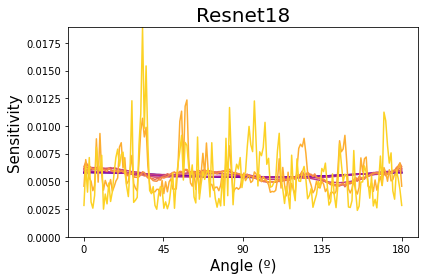

In [24]:
plot_fisher(cnn, "Resnet18", 10, n_angles=180, n_phases=1)

  0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


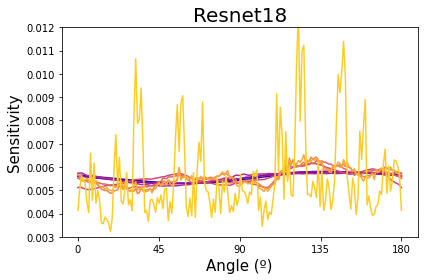

In [42]:
plot_fisher(cnn, "Resnet18", 9, n_angles=180, scale=(0.003,0.012), n_phases=1)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


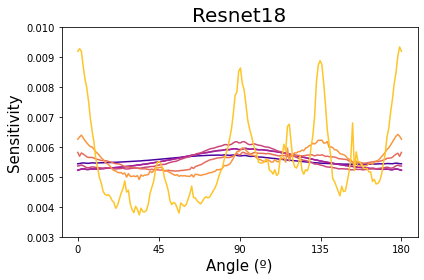

In [36]:
plot_fisher(cnn, "Resnet18", 7, n_angles=180, scale=(0.003,0.01), n_phases=1)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_1211209/1392661651.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_tensor = torch.tensor(theta, dtype=torch.float32)  # Ensure theta is a torch tensor
100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


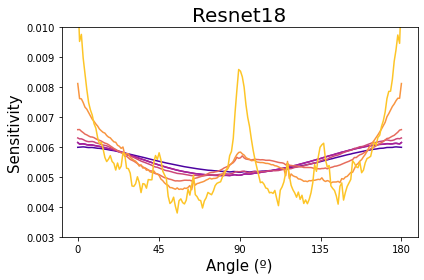

In [47]:
plot_fisher(cnn, "Resnet18", 7, n_angles=180, scale=(0.003,0.01), n_phases=1)